# Python Collaborate Filtering
- MoiveLens 100k [data source](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

In [68]:
import pandas as pd
import numpy as np

In [25]:
# ml-100k csv를 import 한다.
# 해당 scv에는 column 이름이 없으므로, 함께 지정해준다.
df = pd.read_csv('data/ml100k/u.data', sep='\t', names=['UserID', 'ItemID', 'Ratings', 'Timestamp'])

In [29]:
df.tail()

,UserID,ItemID,Ratings,Timestamp
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156
99999,12,203,3,879959583


In [31]:
df.shape

(100000, 4)

# EDA

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([  6110.,      0.,  11370.,      0.,      0.,  27145.,      0.,
         34174.,      0.,  21201.]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

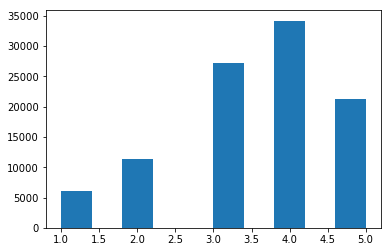

In [37]:
plt.hist(df['Ratings'])

In [38]:
df.groupby(['Ratings'])['UserID'].count()

Ratings
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

(array([  1.14600000e+03,   2.49000000e+02,   1.39000000e+02,
          6.70000000e+01,   3.80000000e+01,   2.40000000e+01,
          7.00000000e+00,   5.00000000e+00,   6.00000000e+00,
          1.00000000e+00]),
 array([   1. ,   59.2,  117.4,  175.6,  233.8,  292. ,  350.2,  408.4,
         466.6,  524.8,  583. ]),
 <a list of 10 Patch objects>)

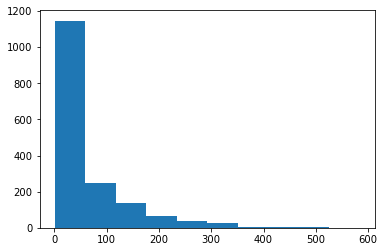

In [39]:
plt.hist(df.groupby(['ItemID'])['ItemID'].count())

# Eval matrix

In [41]:
n_users = df.UserID.unique().shape[0]
n_items = df.ItemID.unique().shape[0]

In [43]:
print(str(n_users), 'users')
print(str(n_items), 'items')

943 users
1682 items


In [44]:
ratings = np.zeros((n_users, n_items))

In [49]:
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

In [51]:
type(ratings)

numpy.ndarray

In [52]:
ratings.shape

(943, 1682)

In [53]:
ratings

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

In [54]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity : {:4.2f}%'.format(sparsity))

Sparsity : 6.30%


# Data set split

In [55]:
from sklearn.cross_validation import train_test_split

In [59]:
ratings_train, ratings_test = train_test_split(ratings, test_size=0.33, random_state=0)

In [64]:
print('train set :', ratings_train.shape)
print('test set :',ratings_test.shape)

train set : (631, 1682)
test set : (312, 1682)


# UBCF
- UBS를 구축하는 단계
    1. 사용자 간 유사도 행렬을 생성한다
    2. 아이템 $i$에 대한 모든 사용자의 평가 가중치를 계산해 활성 사용자 $u$의 해당 아이템에 대해 알려지지 않은 평가값을 예측한다.
        - 가중치는 앞 단계의 해당 사용자와 이웃 사용자 사이에서 계산된 코사인 유사도
    3. 사용자들에게 새로운 아이템을 추천한다.

## 유사도 계산

In [74]:
from sklearn.metrics.pairwise import cosine_distances

In [76]:
dist_out = 1 - cosine_distances(ratings_train)
type(dist_out)

numpy.ndarray

In [77]:
# the dimensions of the distance matrix will be a square matrix of size equal to the number of users.
dist_out.shape

(631, 631)

In [78]:
dist_out

array([[ 1.        ,  0.05352991,  0.02763305, ...,  0.11964898,
         0.14499492,  0.11774518],
       [ 0.05352991,  1.        ,  0.13182819, ...,  0.07307557,
         0.07936599,  0.09276559],
       [ 0.02763305,  0.13182819,  1.        , ...,  0.06945042,
         0.14060773,  0.01721291],
       ..., 
       [ 0.11964898,  0.07307557,  0.06945042, ...,  1.        ,
         0.28846546,  0.04813431],
       [ 0.14499492,  0.07936599,  0.14060773, ...,  0.28846546,
         1.        ,  0.0898513 ],
       [ 0.11774518,  0.09276559,  0.01721291, ...,  0.04813431,
         0.0898513 ,  1.        ]])

## 활성 사용자 평가예측

In [80]:
from sklearn.metrics import mean_squared_error

In [83]:
def get_mse(pred, actual):
    # 0이 아닌 것은 무시
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [84]:
user_pred = dist_out.dot(ratings_train) / np.array([np.abs(dist_out).sum(axis=1)]).T

In [85]:
get_mse(user_pred, ratings_train)

7.728767547000615

In [86]:
get_mse(user_pred, ratings_test)

8.8515306703488807

## KNN UBCF
- 상기 결과는 예측에 모든 사용자의 평가 정보를 선택했기에 RMSE가 큼
- 모든 사용자가 아닌, 유사한 K 명의 사용자를 대상으로 평가하고자 함

In [87]:
from sklearn.neighbors import NearestNeighbors

In [89]:
k = 5
neigh = NearestNeighbors(k, "cosine")
neigh.fit(ratings_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius='cosine')

In [90]:
top_k_distances, top_k_users = neigh.kneighbors(ratings_train, return_distance=True)

In [91]:
print('top k distance :', top_k_distances.shape)
print('top k users :', top_k_users.shape)

top k distance : (631, 5)
top k users : (631, 5)


In [92]:
top_k_users[0]

array([  0, 343, 226, 214, 299])

In [93]:
user_pred_k = np.zeros(ratings_train.shape)
for i in range(ratings_train.shape[0]):
    user_pred_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i])/np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

In [94]:
user_pred_k.shape

(631, 1682)

In [95]:
user_pred_k

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 2.74979331,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.01264246,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [96]:
get_mse(user_pred_k, ratings_train)

8.0488167104255819

In [97]:
get_mse(user_pred_k, ratings_test)

11.510529387315012